# keras EfficientNet


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0
from keras.optimizers import Adam
import os, cv2, json

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

In [2]:
# For easy acces to files
WORK_DIR = "../input/cassava-leaf-disease-classification/"
os.listdir(WORK_DIR)

['train_tfrecords',
 'sample_submission.csv',
 'test_tfrecords',
 'label_num_to_disease_map.json',
 'train_images',
 'train.csv',
 'test_images']

In [3]:
with open('../input/cassava-leaf-disease-classification/label_num_to_disease_map.json', 'r') as file:
    labels = json.load(file)
    
labels

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In [4]:
data = pd.read_csv(WORK_DIR + "train.csv")

In [5]:
data.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

In [6]:
data.dtypes

image_id    object
label        int64
dtype: object

In [7]:
#change for the ImageDatagen and flow_from_dataframe
data.label = data.label.astype("str")

In [8]:
data.dtypes

image_id    object
label       object
dtype: object

In [9]:
data.shape[0]

21397

In [10]:
data.label.value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

### **We have 21397 images for training and don't have an equal number of photos for each class.** 

 I don't know how to deal with the unbalanced image dataset so I'll leave it to the next version.

# Image Visualization


#### Let's first visualize the general data set. 
#### Visualize by class later

In [11]:
IMG_SIZE = 300

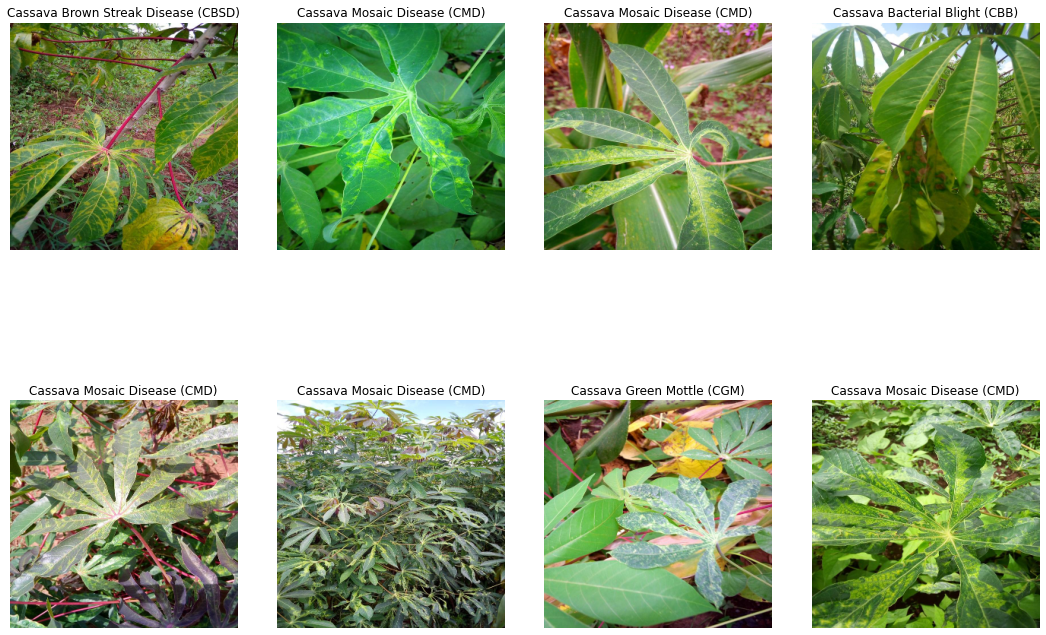

In [12]:
plt.figure(figsize=(15,12))
data_sample = data.sample(9).reset_index(drop=True)

for i in range(8):
    plt.subplot(2,4,i+1)
    
    img = cv2.imread(WORK_DIR + "train_images/" + data_sample.image_id[i])
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.axis("off")
    plt.imshow(img)
    plt.title(labels.get(data_sample.label[i]))
    
plt.tight_layout()
plt.show()

**Cassava Bacterial Blight (CBB)**

In [13]:
labels.get("0")

'Cassava Bacterial Blight (CBB)'

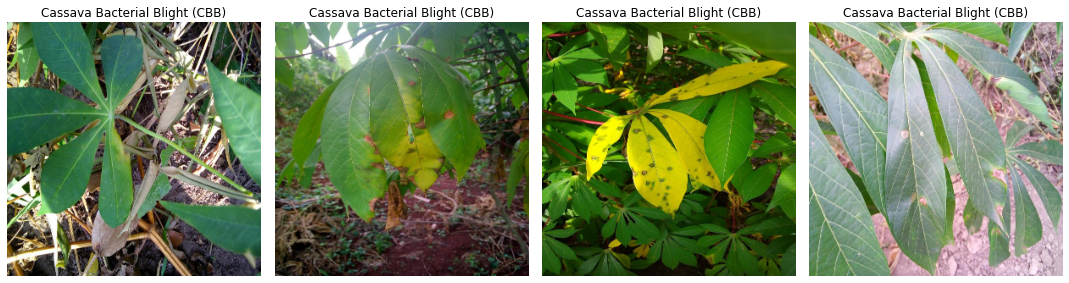

In [14]:
plt.figure(figsize=(15,12))
data_sample = data[data.label=="0"].sample(4).reset_index(drop=True)
for i in range(4):
    plt.subplot(1,4,i+1)
    
    img = cv2.imread(WORK_DIR + "train_images/" + data_sample.image_id[i])
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.axis("off")
    plt.imshow(img)
    plt.title(labels.get(data_sample.label[i]))
    
plt.tight_layout()
plt.show()

**Cassava Brown Streak Disease (CBSD)**

In [15]:
labels.get("1")

'Cassava Brown Streak Disease (CBSD)'

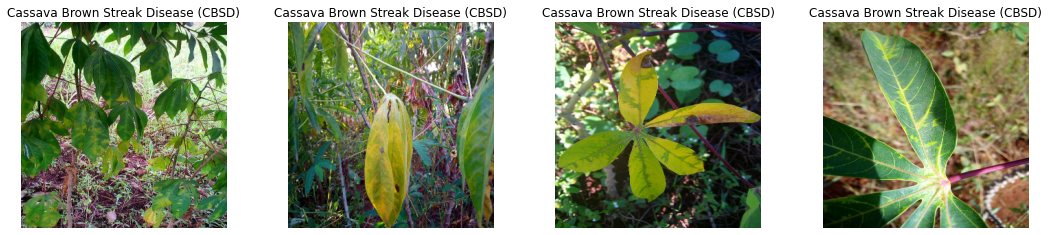

In [16]:
plt.figure(figsize=(15,12))
data_sample = data[data.label=="1"].sample(4).reset_index(drop=True)
for i in range(4):
    plt.subplot(1,4,i+1)
    
    img = cv2.imread(WORK_DIR + "train_images/" + data_sample.image_id[i])
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.axis("off")
    plt.imshow(img)
    plt.title(labels.get(data_sample.label[i]))
    
plt.tight_layout()
plt.show()

**Cassava Green Mottle (CGM)**

In [17]:
labels.get("2")

'Cassava Green Mottle (CGM)'

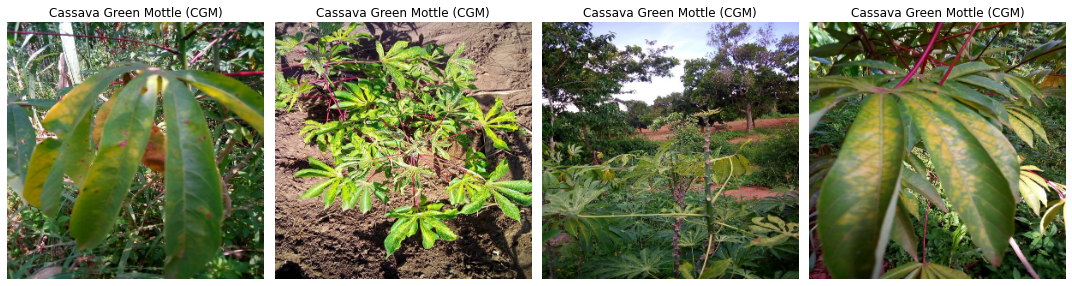

In [18]:
plt.figure(figsize=(15,12))
data_sample = data[data.label=="2"].sample(4).reset_index(drop=True)
for i in range(4):
    plt.subplot(1,4,i+1)
    
    img = cv2.imread(WORK_DIR + "train_images/" + data_sample.image_id[i])
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.axis("off")
    plt.imshow(img)
    plt.title(labels.get(data_sample.label[i]))
    
plt.tight_layout()
plt.show()

**Cassava Mosaic Disease (CMD)**

In [19]:
labels.get("3")

'Cassava Mosaic Disease (CMD)'

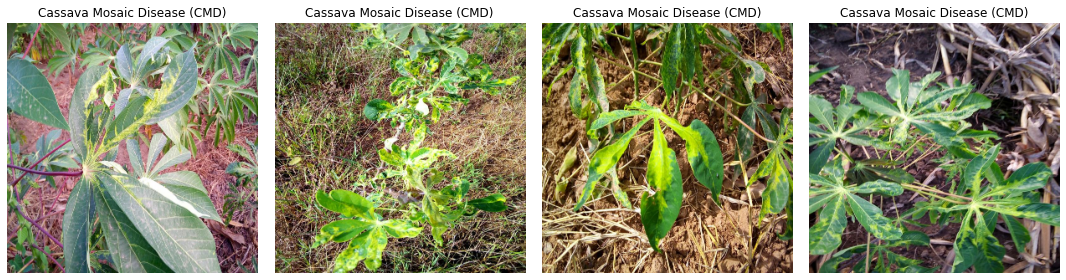

In [20]:
plt.figure(figsize=(15,12))
data_sample = data[data.label=="3"].sample(4).reset_index(drop=True)
for i in range(4):
    plt.subplot(1,4,i+1)
    
    img = cv2.imread(WORK_DIR + "train_images/" + data_sample.image_id[i])
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.axis("off")
    plt.imshow(img)
    plt.title(labels.get(data_sample.label[i]))
    
plt.tight_layout()
plt.show()

**Healthy**

In [21]:
labels.get("4")

'Healthy'

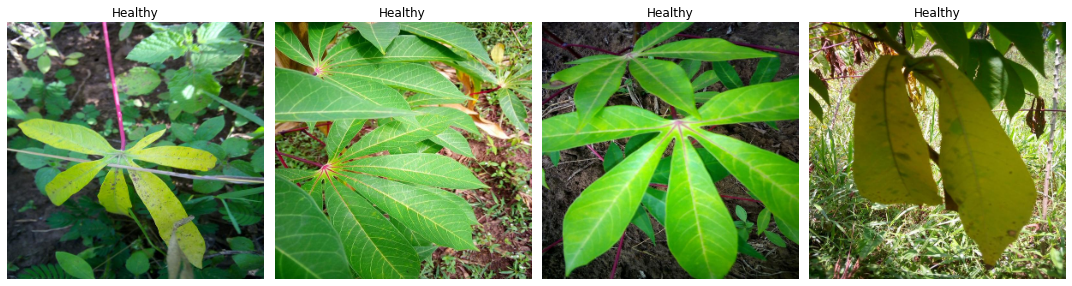

In [22]:
plt.figure(figsize=(15,12))
data_sample = data[data.label=="4"].sample(4).reset_index(drop=True)
for i in range(4):
    plt.subplot(1,4,i+1)
    
    img = cv2.imread(WORK_DIR + "train_images/" + data_sample.image_id[i])
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.axis("off")
    plt.imshow(img)
    plt.title(labels.get(data_sample.label[i]))
    
plt.tight_layout()
plt.show()

# Image Preprocessing, Data Augmentetion


**ImageDataGenerator:** Generate batches of tensor image data with real-time data augmentation.

**flow_from_dataframe:** Takes the dataframe and the path to a directory + generates batches.
The generated batches contain augmented/normalized data.


https://keras.io/api/preprocessing/image/

In [23]:
train_generator = ImageDataGenerator(
                                    #featurewise_center=False,                                    
                                    #samplewise_center=False,
                                    #featurewise_std_normalization=False,
                                    #samplewise_std_normalization=False, 
                                    #zca_whitening=False,
                                    #zca_epsilon=1e-06,
                                    #rotation_range=90,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    #brightness_range=None,
                                    shear_range=25,
                                    zoom_range=0.3,
                                    #channel_shift_range=0.0,
                                    #fill_mode="nearest",
                                    #cval=0.0,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    #rescale=None,
                                    #preprocessing_function=None,
                                    #data_format=None,
                                    validation_split=0.2,
                                    #dtype=None,
) \
        .flow_from_dataframe(
                            data,
                            directory = WORK_DIR + "train_images",
                            x_col = "image_id",
                            y_col = "label",
                            #weight_col = None,
                            target_size = (IMG_SIZE, IMG_SIZE),
                            #color_mode = "rgb",
                            #classes = None,
                            class_mode = "categorical",
                            batch_size = 32,
                            shuffle = True,
                            #seed = 34,
                            #save_to_dir = None,
                            #save_prefix = "",
                            #save_format = "png",
                            subset = "training",
                            #interpolation = "nearest",
                            #validate_filenames = True
)


Found 17118 validated image filenames belonging to 5 classes.


In [24]:
valid_generator = ImageDataGenerator(
                                    validation_split = 0.2
) \
        .flow_from_dataframe(
                            data,
                            directory = WORK_DIR + "train_images",
                            x_col = "image_id",
                            y_col = "label",
                            target_size = (IMG_SIZE, IMG_SIZE),
                            class_mode = "categorical",
                            batch_size = 32,
                            shuffle = True,
                            #seed = 34,
                            subset = "validation")

Found 4279 validated image filenames belonging to 5 classes.


In [25]:
valid_generator.class_indices

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}

# Model

In [26]:
def modelEfficientNetB0():
    
    model = models.Sequential()
    model.add(EfficientNetB0(include_top = False, weights = "imagenet",
                            input_shape=(IMG_SIZE,IMG_SIZE, 3)))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(5, activation = "softmax"))
    
    return model 

In [27]:
model = modelEfficientNetB0()

16711680/16705208 [==============================] - 0s 0us/step


In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 10, 10, 1280)      4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 4,055,976
Trainable params: 4,013,953
Non-trainable params: 42,023
_________________________________________________________________


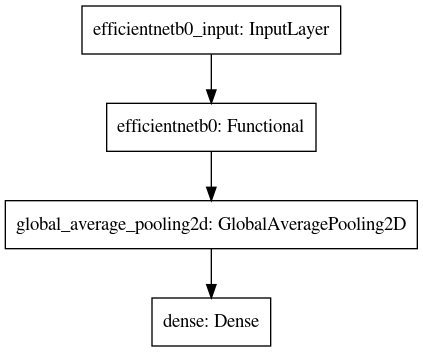

In [29]:
from tensorflow.keras import utils

utils.plot_model(model)

## Callbacks

**ModelCheckpoint**: Callback to save the Keras model or model weights at some frequency.

**EarlyStopping**: Stop training when a monitored metric has stopped improving.

**ReduceLROnPlateau**: Reduce learning rate when a metric has stopped improving.


https://keras.io/api/callbacks/

In [30]:
model_check = ModelCheckpoint(
                            "./firstTry.h5",
                            monitor = "val_loss",
                            verbose = 1,
                            save_best_only = True,
                            save_weights_only = False,
                            mode = "min")

In [31]:
early_stop= EarlyStopping(
                                monitor = "val_loss",
                                min_delta=0.001,
                                patience=3,
                                verbose=1,
                                mode="min",
                                #baseline=None,
                                restore_best_weights=False)

In [32]:
reduce_lr = ReduceLROnPlateau(
                                monitor="val_loss",
                                factor=0.1,
                                patience=3,
                                verbose=1,
                                mode="min",
                                min_delta=0.0001,
                                #cooldown=0,
                                #min_lr=0
)

In [33]:
model.compile(optimizer = "adam",
            loss = "categorical_crossentropy",
            metrics = ["accuracy"])

In [34]:
history = model.fit_generator(train_generator,
                            epochs = 10,
                            validation_data = valid_generator,
                             callbacks = [model_check,early_stop,reduce_lr])


Epoch 1/10
535/535 [==============================] - ETA: 0s - loss: 0.6178 - accuracy: 0.7819
Epoch 00001: val_loss improved from inf to 0.55850, saving model to ./firstTry.h5
535/535 [==============================] - 762s 1s/step - loss: 0.6178 - accuracy: 0.7819 - val_loss: 0.5585 - val_accuracy: 0.8212
Epoch 2/10
535/535 [==============================] - ETA: 0s - loss: 0.4923 - accuracy: 0.8254
Epoch 00002: val_loss improved from 0.55850 to 0.53665, saving model to ./firstTry.h5
535/535 [==============================] - 642s 1s/step - loss: 0.4923 - accuracy: 0.8254 - val_loss: 0.5366 - val_accuracy: 0.8327
Epoch 3/10
535/535 [==============================] - ETA: 0s - loss: 0.4598 - accuracy: 0.8393
Epoch 00003: val_loss improved from 0.53665 to 0.44589, saving model to ./firstTry.h5
535/535 [==============================] - 645s 1s/step - loss: 0.4598 - accuracy: 0.8393 - val_loss: 0.4459 - val_accuracy: 0.8467
Epoch 4/10
535/535 [==============================] - ETA: 0s 

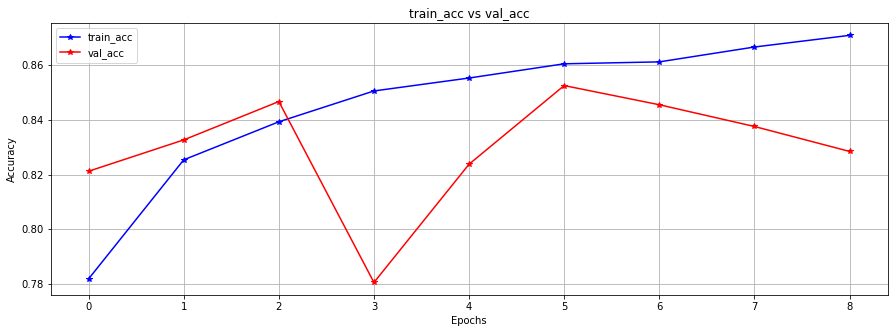

In [35]:
plt.figure(figsize=(15, 5))
plt.plot(history.history['accuracy'], 'b*-', label="train_acc")
plt.plot(history.history['val_accuracy'], 'r*-', label="val_acc")
plt.grid()
plt.title("train_acc vs val_acc")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

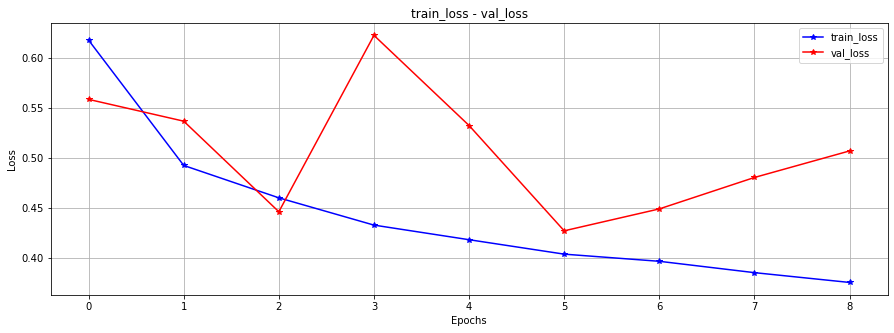

In [36]:
plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'], 'b*-', label="train_loss")
plt.plot(history.history['val_loss'], 'r*-', label="val_loss")
plt.grid()
plt.title("train_loss - val_loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

## Prediction

In [ ]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow import keras
import matplotlib.pyplot as plt
# model = keras.models.load_model("./firstTry.h5")

In [ ]:
preds = []
ss = pd.read_csv(WORK_DIR + "sample_submission.csv")
for image in ss.image_id:
    img = keras.preprocessing.image.load_img(WORK_DIR + "test_images/" + image)
    img = keras.preprocessing.image.img_to_array(img)
    img = keras.preprocessing.image.smart_resize(img, (IMG_SIZE, IMG_SIZE))
    img = np.expand_dims(img, 0)
    prediction = model.predict(img)
    preds.append(np.argmax(prediction))

my_submission = pd.DataFrame({'image_id': ss.image_id, 'label': preds})
my_submission.to_csv('submission.csv', index=False) 

In [ ]:
my_submission